In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import our data
df4=pd.read_csv('engineered_4yr.csv')

In [4]:
df4.describe()

,id,completion_rate_4yr_150nt,size,part_time_share,cost,pell_grant_rate,federal_loan_rate,retention_rate_full_time,share_25_older,two_yr_default_rate,three_yr_default_rate,share_firstgeneration,median_hh_income,pt25,pell_twoyear,incost,pellsq,twoyrdsq
count,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000
mean,207079.243395,0.512205,0.048505,0.143525,0.377736,0.385348,0.563682,0.738958,0.224541,0.063237,0.074953,0.335332,0.308029,0.056903,0.028705,0.131250,0.175828,0.005975
std,89276.531114,0.204163,0.077559,0.162999,0.241605,0.165379,0.196830,0.144208,0.225324,0.044470,0.050710,0.107505,0.115274,0.117150,0.031143,0.117867,0.148596,0.008854
min,100654.000000,0.021600,0.000000,0.000000,0.000000,0.000000,0.000000,0.090900,0.000000,0.000000,0.000000,0.088670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,154058.500000,0.364200,0.008219,0.030250,0.159347,0.267500,0.449450,0.666700,0.061200,0.033000,0.038000,0.265674,0.233988,0.001653,0.009524,0.042160,0.071556,0.001089
50%,190725.000000,0.511600,0.018878,0.090800,0.317277,0.366700,0.589000,0.755000,0.159100,0.054000,0.065000,0.340591,0.299742,0.012947,0.019294,0.090230,0.134469,0.002916
75%,218968.500000,0.655400,0.052344,0.198800,0.552038,0.480350,0.711950,0.833550,0.295300,0.080000,0.100000,0.401697,0.388098,0.052185,0.034777,0.183643,0.230736,0.006400
max,489937.000000,0.982100,0.999940,1.000000,0.978803,0.958600,1.000000,1.000000,0.980800,0.312000,0.331000,0.850909,0.603440,0.771248,0.296806,0.525986,0.918914,0.097344


In [5]:
# create a test (20%)and training (80%) sample
df4test=df4.sample(frac=.2,random_state=1)
df4train=df4.drop(df4test.index)

In [6]:
# look at individual predictor correlations to target variable 
df4_corr = df4train.corr()['completion_rate_4yr_150nt'][3:]
# filter out lower correlated predictors
features_list = df4_corr[abs(df4_corr) > 0.45].sort_values(ascending=False)
print("There are {} strongly correlated values with Completion Rate:\n{}".format(len(features_list), features_list))

There are 12 strongly correlated values with Completion Rate:
retention_rate_full_time    0.699012
incost                      0.604668
median_hh_income            0.550347
cost                        0.543692
twoyrdsq                   -0.475006
pellsq                     -0.540505
share_25_older             -0.548991
pell_twoyear               -0.556141
two_yr_default_rate        -0.593309
pell_grant_rate            -0.621101
share_firstgeneration      -0.653455
three_yr_default_rate      -0.673498
Name: completion_rate_4yr_150nt, dtype: float64


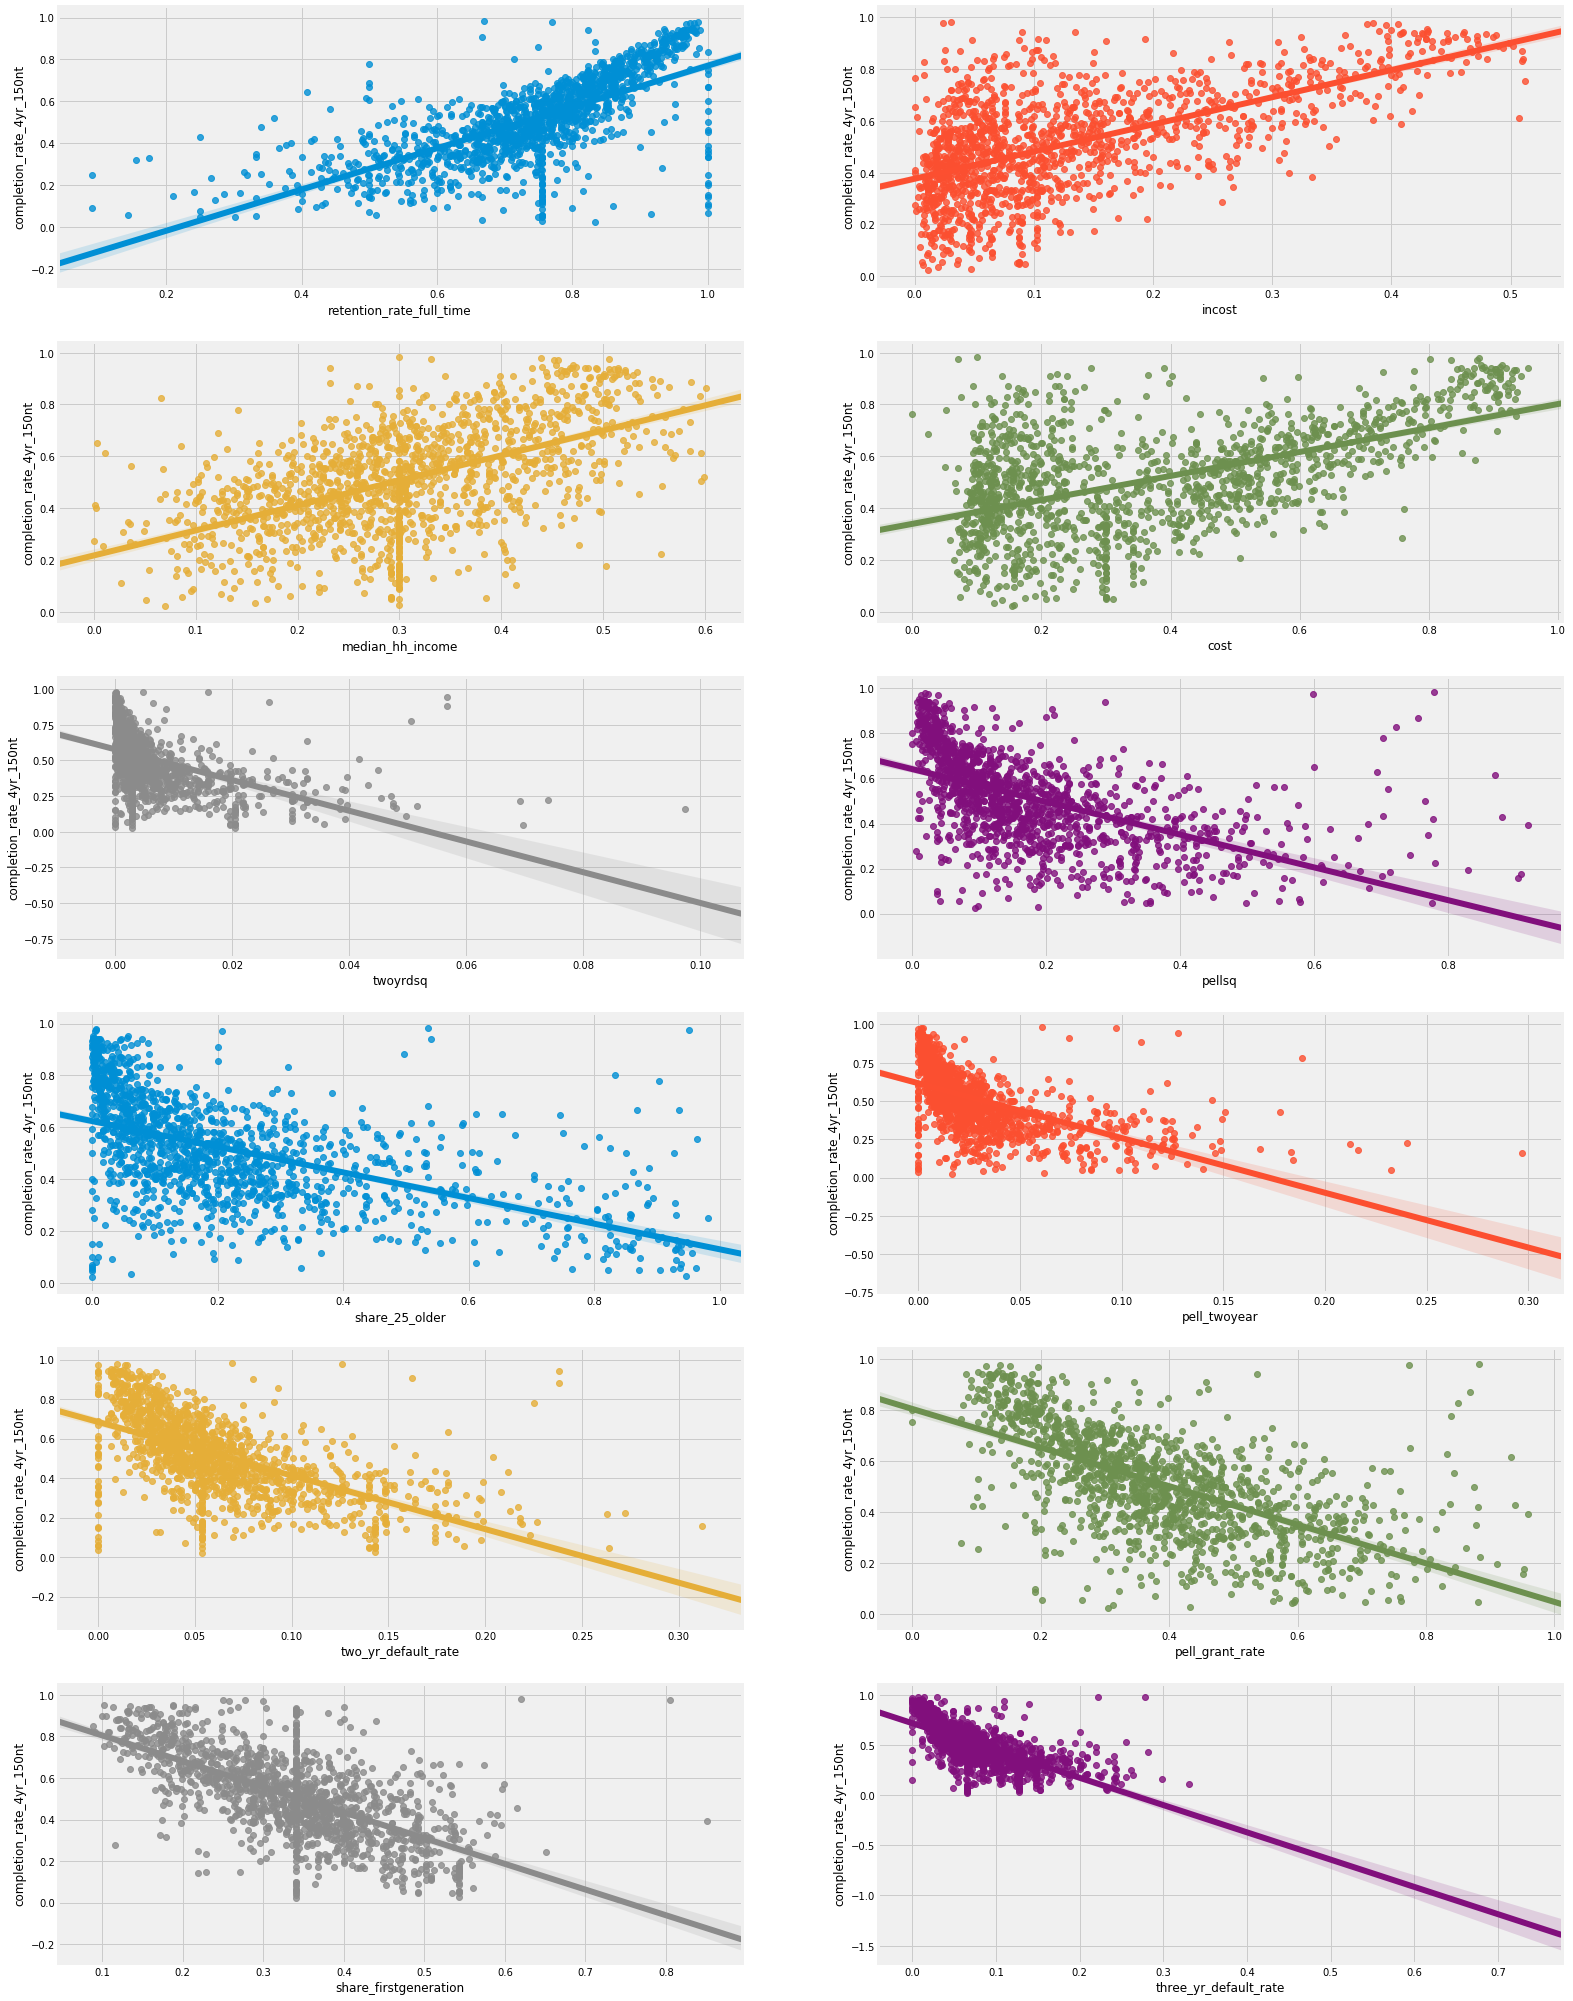

In [7]:
# look for homoscedasticity in this features list
fig, ax = plt.subplots(round(len(features_list) / 2), 2, figsize = (24, 36))

# create arrays for our features and our target
Y=df4train['completion_rate_4yr_150nt']
X=df4train[[x for x in features_list.index]]
for i, ax in enumerate(fig.axes):
    if i < len(features_list):
        sns.regplot(x=df4train[features_list.index[i]],y=Y, data=df4train[features_list.index], ax=ax)

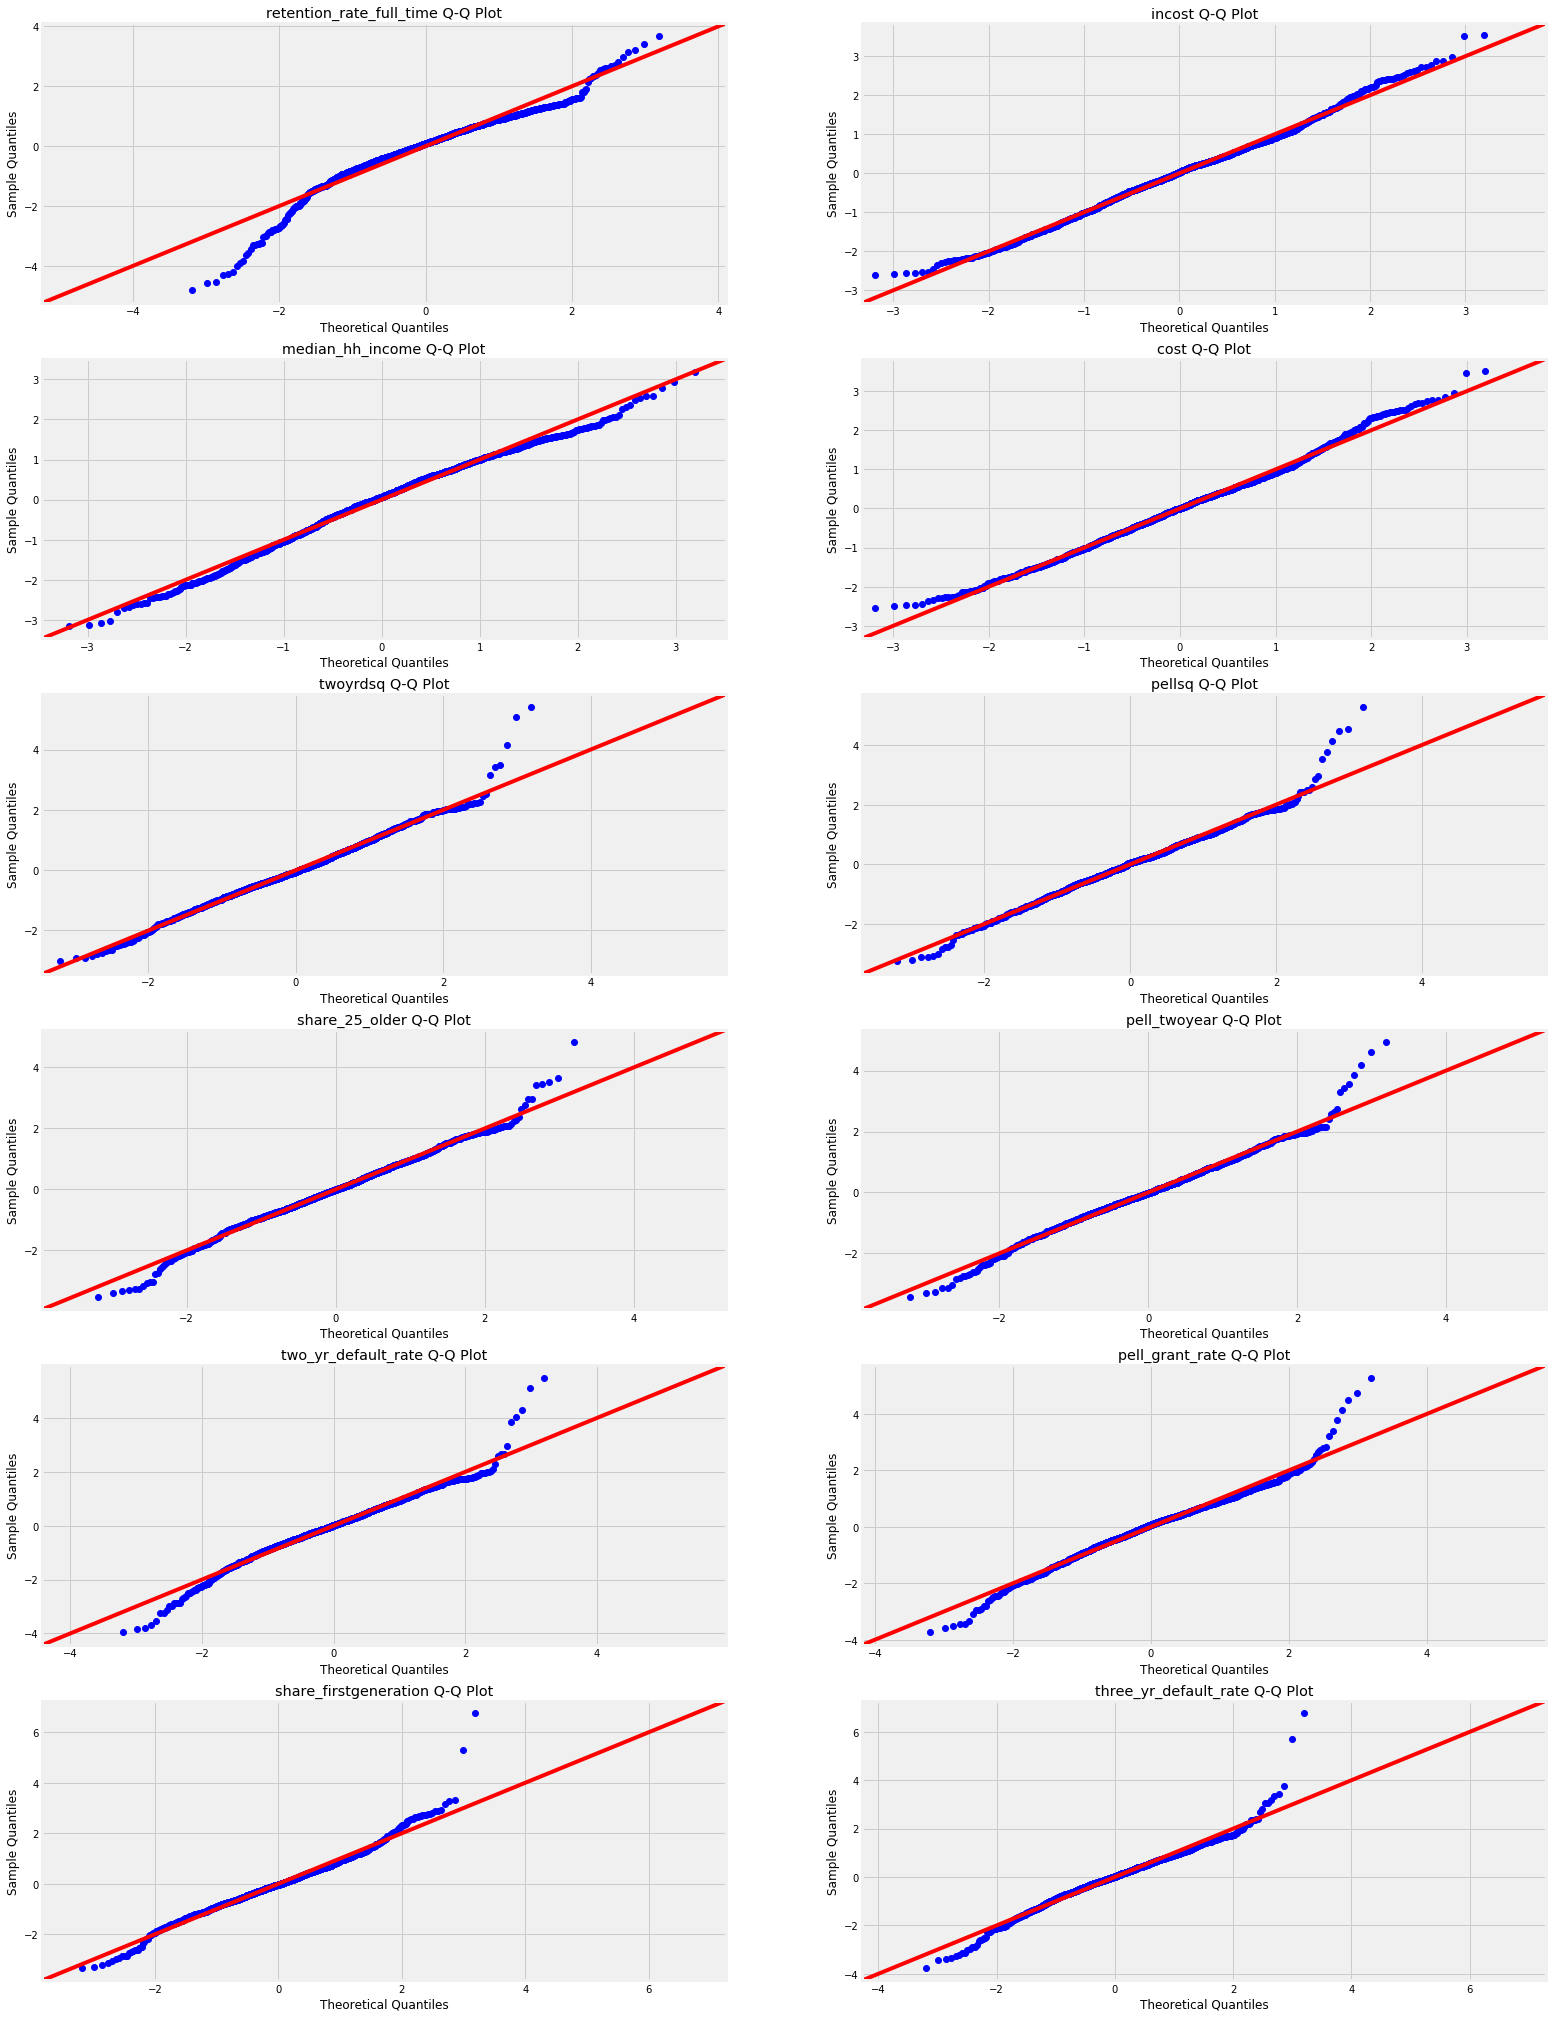

In [8]:
# look for normality in the residuals for these features to ensure our assumptions for linear regression hold up
fig, ax = plt.subplots(round(len(features_list) / 2), 2, figsize = (24, 36))

for label,ax in zip(features_list.index, fig.axes):
    f = f'completion_rate_4yr_150nt~{label}'
    model = smf.ols(formula=f, data=df4train).fit()

    resid1 = model.resid
    ax.set_title(f'{label} Q-Q Plot')
    fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True, ax=ax)
    fig.show();

In [9]:
# create a multi-linear regression model
f='completion_rate_4yr_150nt~cost+median_hh_income+pellsq+two_yr_default_rate+share_25_older+share_firstgeneration+pell_grant_rate+three_yr_default_rate+incost+retention_rate_full_time+twoyrdsq+pell_twoyear'
model=smf.ols(formula=f, data=df4train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     completion_rate_4yr_150nt   R-squared:                       0.716
Model:                                   OLS   Adj. R-squared:                  0.714
Method:                        Least Squares   F-statistic:                     296.8
Date:                       Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                               10:58:20   Log-Likelihood:                 1136.5
No. Observations:                       1423   AIC:                            -2247.
Df Residuals:                           1410   BIC:                            -2179.
Df Model:                                 12                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3776      0.036     10.531      0.000       0.307       0.448
cost                         0.2035      0.044      4.676      0.000       0.118       0.289
median_hh_income             0.2965      0.050      5.970      0.000       0.199       0.394
pellsq                       0.6233      0.103      6.045      0.000       0.421       0.826
two_yr_default_rate         -0.9390      0.270     -3.480      0.001      -1.468      -0.410
share_25_older              -0.1415      0.017     -8.146      0.000      -0.176      -0.107
share_firstgeneration       -0.1290      0.045     -2.859      0.004      -0.217      -0.040
pell_grant_rate             -0.7070      0.088     -8.016      0.000      -0.880      -0.534
three_yr_default_rate       -0.5200      0.107     -4.865      0.000      -0.730      -0.310
incost                      -0.2694      0.113     -2.389      0.017      -0.491      -0.048
retention_rate_full_time     0.4263      0.027     15.606      0.000       0.373       0.480
twoyrdsq                     0.5529      1.320      0.419      0.675      -2.036       3.141
pell_twoyear                 0.7127      0.517      1.378      0.169      -0.302       1.728
==============================================================================
Omnibus:                      198.386   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2227.047
Skew:                           0.188   Prob(JB):                         0.00
Kurtosis:                       9.117   Cond. No.                         690.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# the residual for retention_rate_full_time is not normal, but is significant as a predictor so we have chosen to keep it
#features_list.drop('retention_rate_full_time',inplace=True)

In [11]:
# two year loan default rate appear heteroscedastic and do not contribute greatly to the R**2
features_list.drop('twoyrdsq',inplace=True)

In [12]:
# the engineered feature of pell grant rate and two year default rate appears heteroscedastic
features_list.drop('pell_twoyear',inplace=True)

In [13]:
# remaining features to look at
features_list

incost                   0.604668
median_hh_income         0.550347
cost                     0.543692
pellsq                  -0.540505
share_25_older          -0.548991
two_yr_default_rate     -0.593309
pell_grant_rate         -0.621101
share_firstgeneration   -0.653455
three_yr_default_rate   -0.673498
Name: completion_rate_4yr_150nt, dtype: float64

In [20]:
# create a multi-linear regression model
f='completion_rate_4yr_150nt~cost+median_hh_income+pellsq+share_25_older+share_firstgeneration+pell_grant_rate+three_yr_default_rate+retention_rate_full_time+incost'
model=smf.ols(formula=f, data=df4train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     completion_rate_4yr_150nt   R-squared:                       0.712
Model:                                   OLS   Adj. R-squared:                  0.710
Method:                        Least Squares   F-statistic:                     388.2
Date:                       Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                               11:10:45   Log-Likelihood:                 1125.6
No. Observations:                       1423   AIC:                            -2231.
Df Residuals:                           1413   BIC:                            -2179.
Df Model:                                  9                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3632      0.036     10.122      0.000       0.293       0.434
cost                         0.2196      0.044      5.033      0.000       0.134       0.305
median_hh_income             0.3182      0.050      6.411      0.000       0.221       0.416
pellsq                       0.7324      0.086      8.542      0.000       0.564       0.901
share_25_older              -0.1386      0.017     -7.933      0.000      -0.173      -0.104
share_firstgeneration       -0.1501      0.045     -3.347      0.001      -0.238      -0.062
pell_grant_rate             -0.7649      0.084     -9.150      0.000      -0.929      -0.601
three_yr_default_rate       -0.7897      0.088     -8.934      0.000      -0.963      -0.616
retention_rate_full_time     0.4249      0.027     15.498      0.000       0.371       0.479
incost                      -0.2938      0.113     -2.595      0.010      -0.516      -0.072
==============================================================================
Omnibus:                      188.967   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1888.737
Skew:                           0.206   Prob(JB):                         0.00
Kurtosis:                       8.629   Cond. No.                         69.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

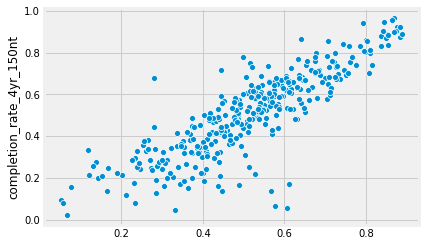

In [21]:
# plot out our predicted values for our test sample compared with the actual observed values
y_pred=model.predict(df4test)
sns.scatterplot(x=y_pred, y=df4test.completion_rate_4yr_150nt)